## 0. Load the libraries

In [4]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [174]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
import numpy as np
import io
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb
from tqdm import tqdm
import time

# 1. Retrieve Data



## 1.1 Load parameters data

In [6]:
parameters_url = "https://dataset.api.hub.geosphere.at/v1/station/historical/klima-v2-1d/metadata/parameters"

response = requests.get(parameters_url)

In [7]:
parameters_data = pd.read_csv(io.StringIO(response.text))

# Extract the first column
parameter_names = parameters_data.iloc[:, 0]
parameter_names_list = parameter_names.tolist()
print(parameter_names_list)

['bewd_i', 'bewd_i_flag', 'bewd_ii', 'bewd_ii_flag', 'bewd_iii', 'bewd_iii_flag', 'bewm_i', 'bewm_i_flag', 'bewm_ii', 'bewm_ii_flag', 'bewm_iii', 'bewm_iii_flag', 'bewm_mittel', 'bewm_mittel_flag', 'bft6', 'bft6_flag', 'bft8', 'bft8_flag', 'cglo_j', 'cglo_j_flag', 'dampf_i', 'dampf_i_flag', 'dampf_ii', 'dampf_ii_flag', 'dampf_iii', 'dampf_iii_flag', 'dampf_mittel', 'dampf_mittel_flag', 'dd32_i', 'dd32_i_flag', 'dd32_ii', 'dd32_ii_flag', 'dd32_iii', 'dd32_iii_flag', 'erdb_i', 'erdb_i_flag', 'erdb_ii', 'erdb_ii_flag', 'erdb_iii', 'erdb_iii_flag', 'ffx', 'ffx_flag', 'gew', 'gew_flag', 'glatt', 'glatt_flag', 'nebel', 'nebel_flag', 'p_i', 'p_i_flag', 'p_ii', 'p_ii_flag', 'p_iii', 'p_iii_flag', 'p_mittel', 'p_mittel_flag', 'raureif', 'raureif_flag', 'reif', 'reif_flag', 'rfb_i', 'rfb_i_flag', 'rfb_ii', 'rfb_ii_flag', 'rfb_iii', 'rfb_iii_flag', 'rfb_mittel', 'rfb_mittel_flag', 'rf_i', 'rf_i_flag', 'rf_ii', 'rf_ii_flag', 'rf_iii', 'rf_iii_flag', 'rf_mittel', 'rf_mittel_flag', 'rr', 'rra_manu',

## 1.2 Load the main dataset for years 2016-2020

In [89]:
selected_stations = pd.read_csv("data/distributed_stations.csv")["id"].tolist()

api_url = "https://dataset.api.hub.geosphere.at/v1/station/historical/klima-v2-1d"

# Define the query parameters
query_params = {
    "parameters": parameter_names_list,  # Parameter
    "start": "2016-01-01T00:00",  # Start date
    "end": "2020-12-31T23:59",  # End date
    "station_ids": selected_stations,  # Station IDs, comma-separated
    "output_format": "csv",  # Output format
}

# Make the GET request
response = requests.get(api_url, params=query_params)

# Check if the request was successful
if response.status_code == 200:
    # Save the response content to a CSV file
    with open("data/full_dataset.csv", "wb") as file:
        file.write(response.content)
    print("Data retrieved and saved as 'full_dataset.csv'")
else:
    # Print error details if the request fails
    print(f"Failed to retrieve data. Status code: {response.status_code}")
    print(response.json())

Data retrieved and saved as 'full_dataset.csv'


# 2. Data inspection

In [90]:
file_path = "data/full_dataset.csv"
data = pd.read_csv(file_path)

print(data.shape)

(54810, 133)


In [91]:
print(data.head())

                     time  station  bewd_i  bewd_i_flag  bewd_ii  \
0  2016-01-01T00:00+00:00        8     2.0           20      1.0   
1  2016-01-01T00:00+00:00       66     2.0           20      NaN   
2  2016-01-01T00:00+00:00       68     2.0           20      2.0   
3  2016-01-01T00:00+00:00       93     2.0           20      2.0   
4  2016-01-01T00:00+00:00       27     NaN           20      NaN   

   bewd_ii_flag  bewd_iii  bewd_iii_flag  bewm_i  bewm_i_flag  ...  \
0            20       2.0             20    10.0           20  ...   
1            20       NaN             20     9.0           20  ...   
2            20       NaN             20    10.0           20  ...   
3            20       2.0             20    10.0           20  ...   
4            20       NaN             20     NaN           20  ...   

   vvbft_i_flag  vvbft_ii  vvbft_ii_flag  vvbft_iii  vvbft_iii_flag  \
0            20       1.0             20        0.0              20   
1            20       1.0   

In [92]:
# Rename time column to date and convert to datetime format
data = data.rename(columns={'time': 'date'})
data['date'] = pd.to_datetime(data['date'])

# Extract date components
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day

print(data.head())

                       date  station  bewd_i  bewd_i_flag  bewd_ii  \
0 2016-01-01 00:00:00+00:00        8     2.0           20      1.0   
1 2016-01-01 00:00:00+00:00       66     2.0           20      NaN   
2 2016-01-01 00:00:00+00:00       68     2.0           20      2.0   
3 2016-01-01 00:00:00+00:00       93     2.0           20      2.0   
4 2016-01-01 00:00:00+00:00       27     NaN           20      NaN   

   bewd_ii_flag  bewd_iii  bewd_iii_flag  bewm_i  bewm_i_flag  ...  vvbft_iii  \
0            20       2.0             20    10.0           20  ...        0.0   
1            20       NaN             20     9.0           20  ...        1.0   
2            20       NaN             20    10.0           20  ...        1.0   
3            20       2.0             20    10.0           20  ...        2.0   
4            20       NaN             20     NaN           20  ...        1.0   

   vvbft_iii_flag  vv_mittel  vv_mittel_flag   zeitx  zeitx_flag  substation  \
0           

In [93]:
data = data.rename(columns={'station': 'id'})

stations = pd.read_csv("data/distributed_stations.csv")

#add information about stations to the main dataset
merged_data = pd.merge(data, stations[["id", "lat", "lon", "name"]], on="id", how="left")
print(merged_data)

                           date  id  bewd_i  bewd_i_flag  bewd_ii  \
0     2016-01-01 00:00:00+00:00   8     2.0           20      1.0   
1     2016-01-01 00:00:00+00:00  66     2.0           20      NaN   
2     2016-01-01 00:00:00+00:00  68     2.0           20      2.0   
3     2016-01-01 00:00:00+00:00  93     2.0           20      2.0   
4     2016-01-01 00:00:00+00:00  27     NaN           20      NaN   
...                         ...  ..     ...          ...      ...   
54805 2020-12-31 00:00:00+00:00  37     0.0           20      0.0   
54806 2020-12-31 00:00:00+00:00  20     NaN           20      NaN   
54807 2020-12-31 00:00:00+00:00  71     2.0           20      2.0   
54808 2020-12-31 00:00:00+00:00  43     NaN           20      NaN   
54809 2020-12-31 00:00:00+00:00  15     NaN           20      NaN   

       bewd_ii_flag  bewd_iii  bewd_iii_flag  bewm_i  bewm_i_flag  ...  \
0                20       2.0             20    10.0           20  ...   
1                20    

## 2.1 Flag columns

In [94]:
quality_flag_columns = [col for col in merged_data.columns if 'flag' in col]

In [95]:
data_cleaned = merged_data.drop(columns=quality_flag_columns)
print("New dataset size after removing flag columns:", data_cleaned.shape)

New dataset size after removing flag columns: (54810, 74)


## 2.2 Aggregated features

In [96]:
data_cleaned = data_cleaned.drop(['bewm_mittel','dampf_mittel', 'p_mittel', 'rf_mittel', 'vv_mittel', 'rr', 'rra_manu'], axis=1)
print("New dataset size after removing aggregated features:", data_cleaned.shape)

New dataset size after removing aggregated features: (54810, 67)


# 3. Visualizations

## 3.1 Indicator columns

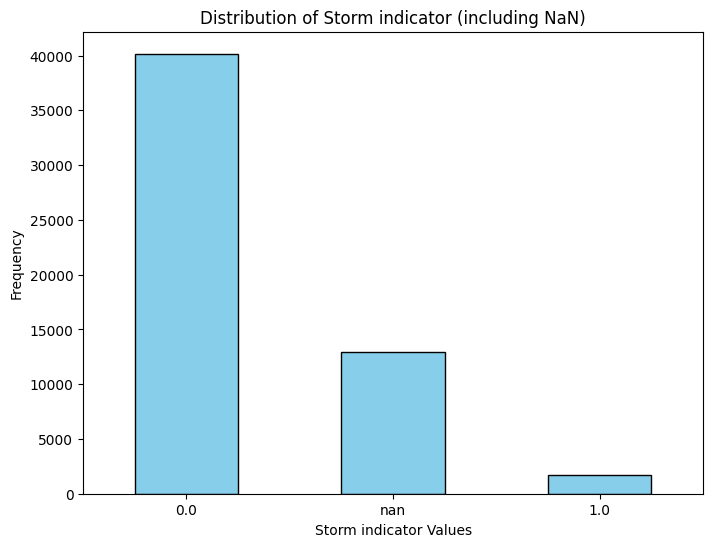

In [97]:
# Calculate value counts, including NaN
value_counts = data_cleaned['bft6'].value_counts(dropna=False)

# Create the bar plot
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Storm indicator (including NaN)')
plt.xlabel('Storm indicator Values')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.show()

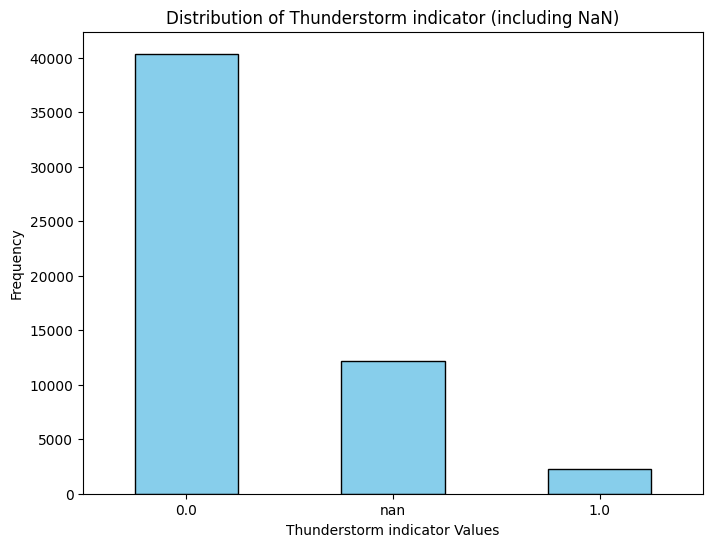

In [98]:
# Calculate value counts, including NaN
value_counts = data_cleaned['gew'].value_counts(dropna=False)

# Create the bar plot
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Thunderstorm indicator (including NaN)')
plt.xlabel('Thunderstorm indicator Values')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.show()

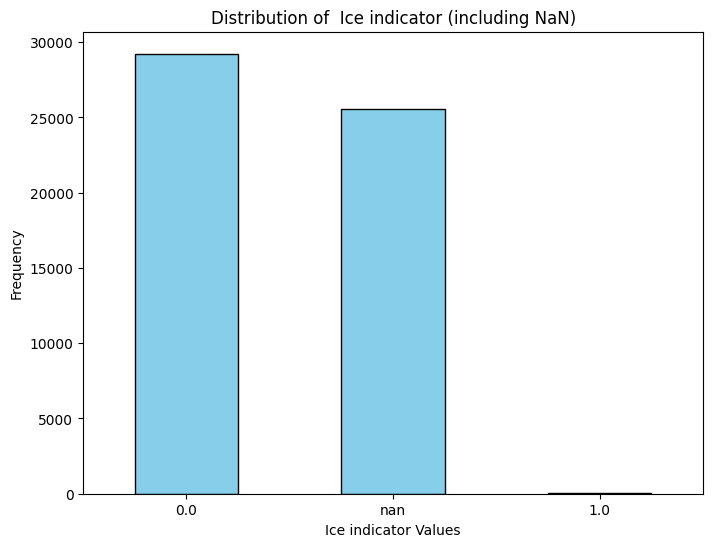

In [99]:
# Calculate value counts, including NaN
value_counts = data_cleaned['glatt'].value_counts(dropna=False)

# Create the bar plot
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of  Ice indicator (including NaN)')
plt.xlabel('Ice indicator Values')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.show()

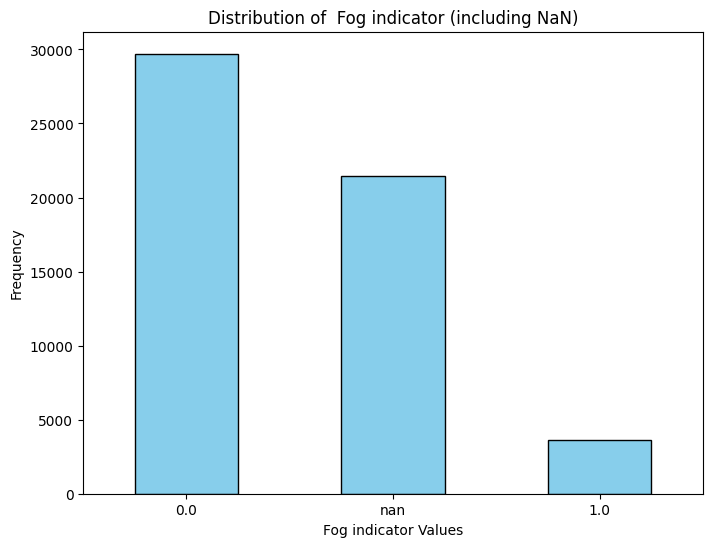

In [100]:
# Calculate value counts, including NaN
value_counts = data_cleaned['nebel'].value_counts(dropna=False)

# Create the bar plot
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of  Fog indicator (including NaN)')
plt.xlabel('Fog indicator Values')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.show()

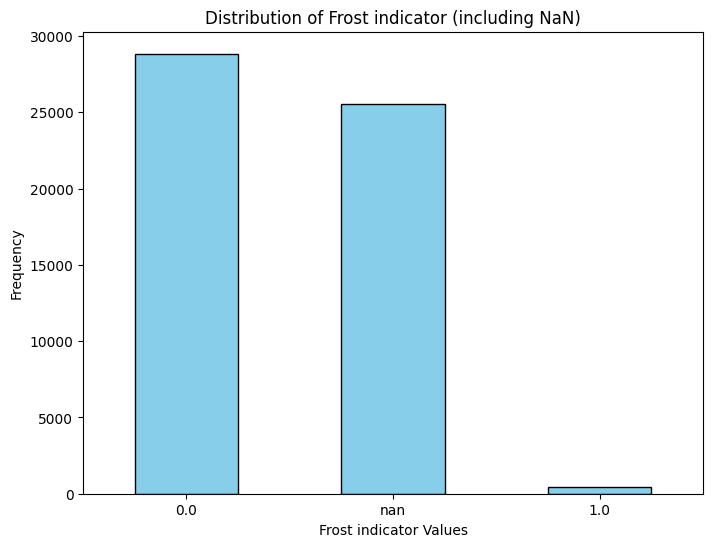

In [101]:
# Calculate value counts, including NaN
value_counts = data_cleaned['raureif'].value_counts(dropna=False)

# Create the bar plot
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Frost indicator (including NaN)')
plt.xlabel('Frost indicator Values')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.show()

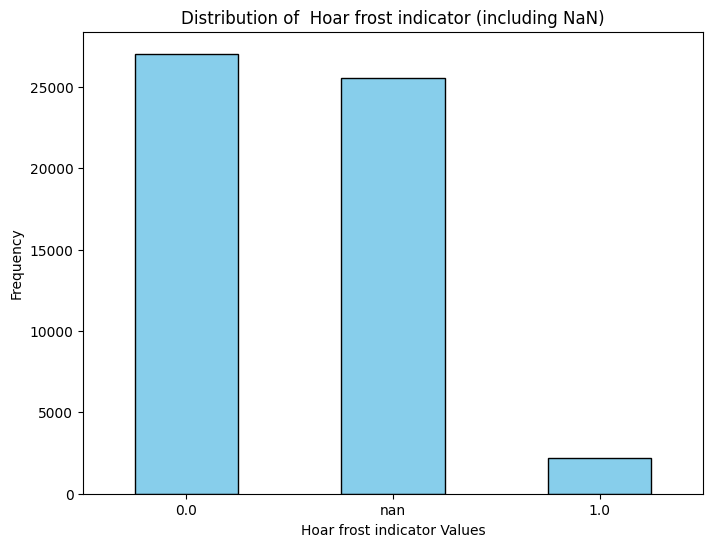

In [102]:
# Calculate value counts, including NaN
value_counts = data_cleaned['reif'].value_counts(dropna=False)

# Create the bar plot
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of  Hoar frost indicator (including NaN)')
plt.xlabel('Hoar frost indicator Values')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.show()

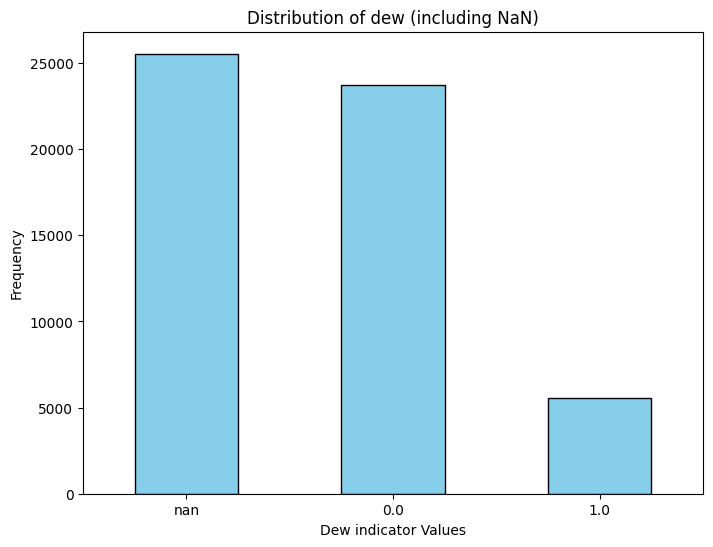

In [103]:
# Calculate value counts, including NaN
value_counts = data_cleaned['tau'].value_counts(dropna=False)

# Create the bar plot
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of dew (including NaN)')
plt.xlabel('Dew indicator Values')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.show()

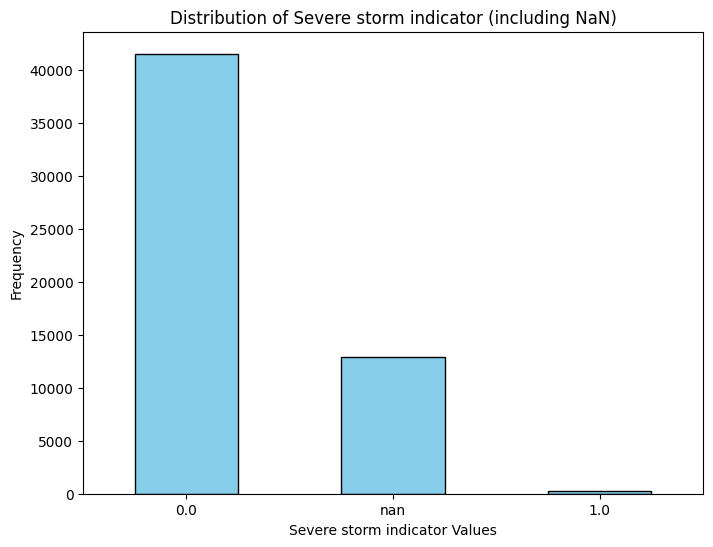

In [104]:
value_counts = data_cleaned['bft8'].value_counts(dropna=False)

# Create the bar plot
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Severe storm indicator (including NaN)')
plt.xlabel('Severe storm indicator Values')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

The visualizations above show the distribution of several meteorological indicators with three primary values: 0 (absence), 1 (presence), and NaN (missing values). We can notice a heavy class imbalance - in most cases, 1 (indicating a severe condition like a storm) is much less frequent than 0. Also for some cases the proportion of missing values is very high (>50%), so we will consider dropping these columsn as they may not provide useful information (in section Missing Values).

## 3.2 Nominal Features

C:\Users\Мария\AppData\Local\Temp\ipykernel_15616\3675323513.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([rra_manu_mapping[int(float(label.get_text()))] for label in ax.get_xticklabels()])


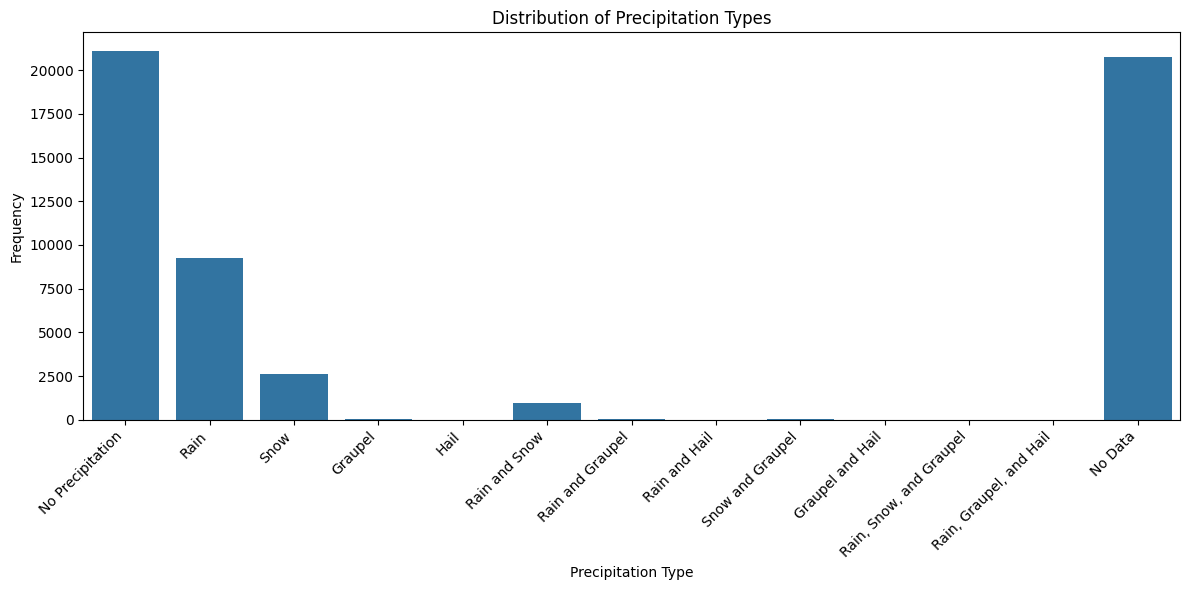

In [105]:
# Mapping for rra_manu codes to descriptions, including NaN
rra_manu_mapping = {
    0: 'No Precipitation',
    1: 'Rain',
    2: 'Snow',
    3: 'Graupel',
    4: 'Hail',
    5: 'Rain and Snow',
    6: 'Rain and Graupel',
    7: 'Rain and Hail',
    8: 'Snow and Graupel',
    9: 'Graupel and Hail',
    10: 'Rain, Snow, and Graupel',
    11: 'Rain, Graupel, and Hail',
    12: 'Snow and Hail',
    13: 'Rain, Snow, and Hail',
    14: 'Snow, Graupel, and Hail',
    15: 'Rain, Snow, Graupel, and Hail',
    99: 'No Data'
}

# Replace NaN values in 'rra_manu_i' with a string '99' temporarily for plotting
data_cleaned['rra_manu_i_plot'] = data_cleaned['rra_manu_i'].fillna(99)

# Plotting the distribution of precipitation types
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='rra_manu_i_plot', data=data_cleaned)
ax.set_xticklabels([rra_manu_mapping[int(float(label.get_text()))] for label in ax.get_xticklabels()])
plt.xlabel("Precipitation Type")
plt.ylabel("Frequency")
plt.title("Distribution of Precipitation Types")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Remove the temporary column after plotting
data_cleaned.drop(columns=['rra_manu_i_plot'], inplace=True)


In [106]:
# Define the set of values indicating rain in the 'rra_manu_i' column
rain_values = [1, 5, 6, 7, 10, 11, 13, 15]

# Create the 'regen_i' column based on the condition
data_cleaned['regen_i'] = data_cleaned['rra_manu_i'].apply(lambda x: 1 if x in rain_values else 0)
data_cleaned['regen_ii'] = data_cleaned['rra_manu_iii'].apply(lambda x: 1 if x in rain_values else 0)

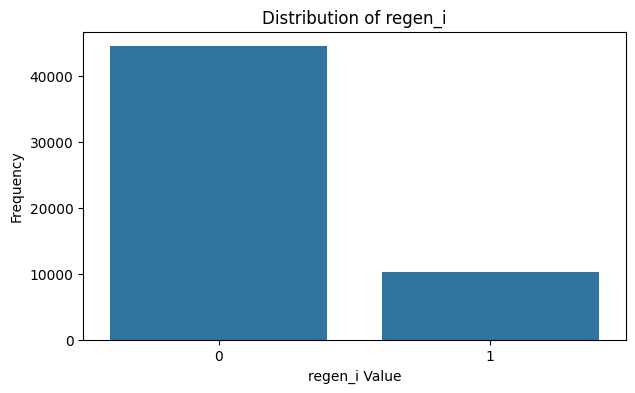

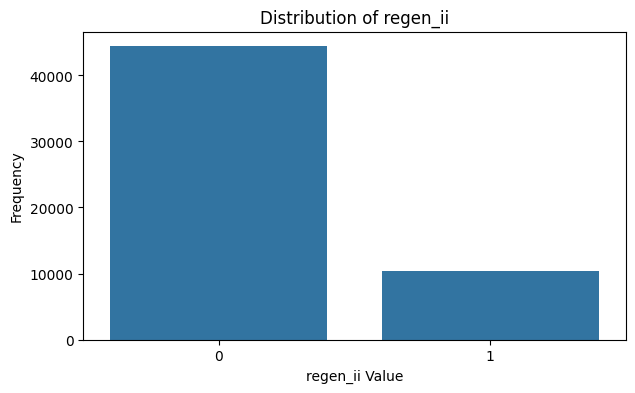

In [107]:
plt.figure(figsize=(7, 4))
sns.countplot(x='regen_i', data=data_cleaned)
plt.title('Distribution of regen_i')
plt.xlabel('regen_i Value')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(7, 4))
sns.countplot(x='regen_ii', data=data_cleaned)
plt.title('Distribution of regen_ii')
plt.xlabel('regen_ii Value')
plt.ylabel('Frequency')
plt.show()

C:\Users\Мария\AppData\Local\Temp\ipykernel_15616\2307219721.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([soil_condition_mapping[int(float(label.get_text()))] for label in ax.get_xticklabels()])


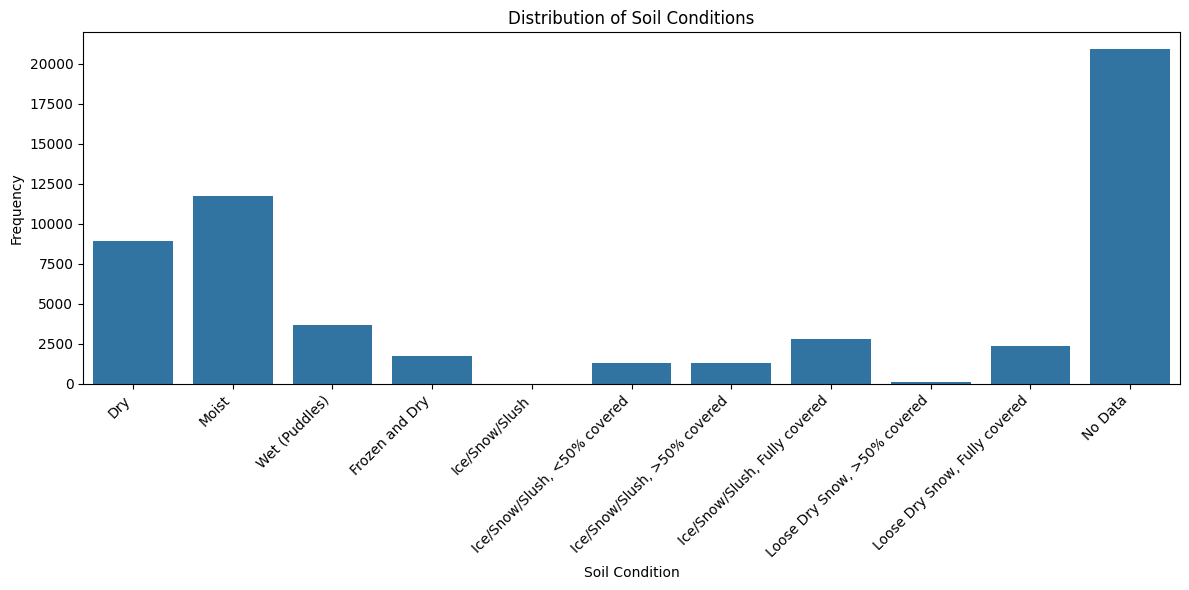

In [108]:
# Mapping for soil condition codes to descriptions
soil_condition_mapping = {
    0: 'Dry',
    1: 'Moist',
    2: 'Wet (Puddles)',
    3: 'Frozen and Dry',
    4: 'Ice/Snow/Slush',
    5: 'Ice/Snow/Slush, <50% covered',
    6: 'Ice/Snow/Slush, >50% covered',
    7: 'Ice/Snow/Slush, Fully covered',
    8: 'Loose Dry Snow, >50% covered',
    9: 'Loose Dry Snow, Fully covered',
    99: 'No Data'
}

# Replace NaN values in 'erdb_i' with a string 'NaN' temporarily for plotting
data_cleaned['erdb_i_plot'] = data_cleaned['erdb_i'].fillna(99)

# Plotting the distribution of soil conditions
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='erdb_i_plot', data=data_cleaned)
ax.set_xticklabels([soil_condition_mapping[int(float(label.get_text()))] for label in ax.get_xticklabels()])
plt.xlabel("Soil Condition")
plt.ylabel("Frequency")
plt.title("Distribution of Soil Conditions")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Remove the temporary column after plotting
data_cleaned.drop(columns=['erdb_i_plot'], inplace=True)


C:\Users\Мария\AppData\Local\Temp\ipykernel_15616\2880854677.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([snow_type_mapping[int(float(label.get_text()))] for label in ax.get_xticklabels()])


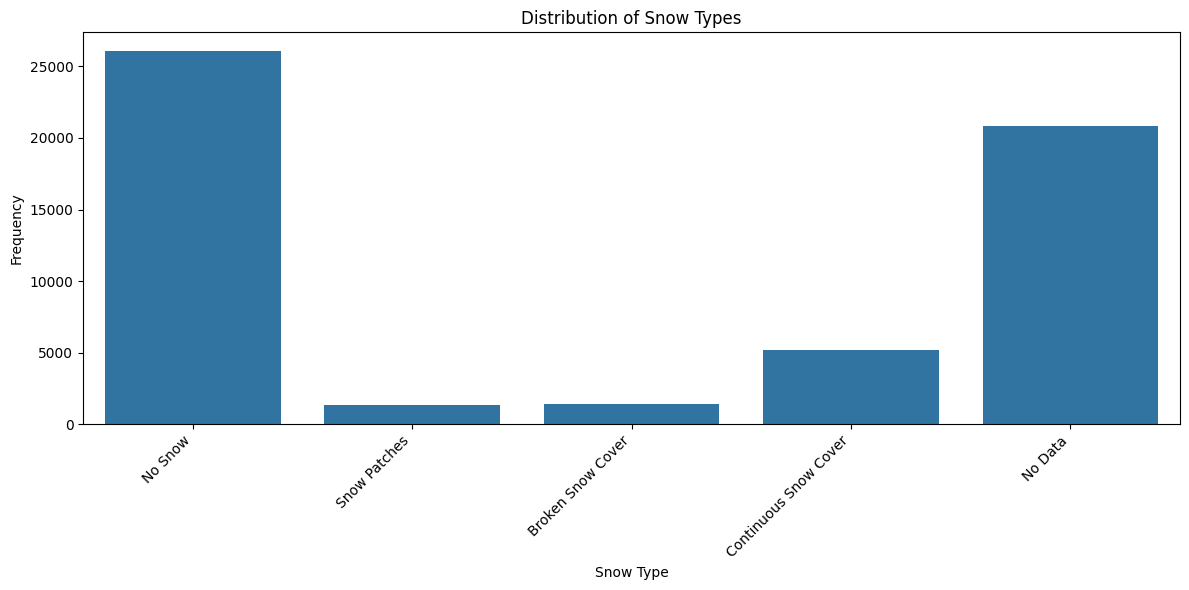

In [109]:
# Mapping for snow type codes to descriptions
snow_type_mapping = {
    0: 'No Snow',
    1: 'Snow Patches',
    2: 'Broken Snow Cover',
    3: 'Continuous Snow Cover',
    9: 'No Data'
}

# Replace NaN values in 'sha_manu' with a string 'NaN' temporarily for plotting
data_cleaned['sha_manu_plot'] = data_cleaned['sha_manu'].fillna(9)

# Plotting the distribution of snow types
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='sha_manu_plot', data=data_cleaned)
ax.set_xticklabels([snow_type_mapping[int(float(label.get_text()))] for label in ax.get_xticklabels()])

plt.xlabel("Snow Type")
plt.ylabel("Frequency")
plt.title("Distribution of Snow Types")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Remove the temporary column after plotting
data_cleaned.drop(columns=['sha_manu_plot'], inplace=True)


In [110]:
data_cleaned['is_snowy'] = data_cleaned['sha_manu'].apply(lambda x: 1 if x in [1, 2, 3] else 0 if x == 0 else np.nan)

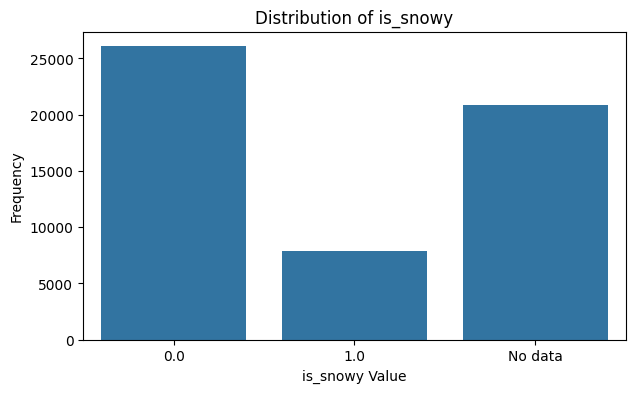

In [111]:
# Replace NaN values in 'is_snowy' with a temporary label for plotting
data_cleaned['is_snowy_plot'] = data_cleaned['is_snowy'].fillna('No data')

# Create the plot
plt.figure(figsize=(7, 4))
sns.countplot(x='is_snowy_plot', data=data_cleaned)
plt.title('Distribution of is_snowy')
plt.xlabel('is_snowy Value')
plt.ylabel('Frequency')
plt.show()

# Remove the temporary column after plotting
data_cleaned.drop(columns=['is_snowy_plot'], inplace=True)

## 3.3 Numerical Features

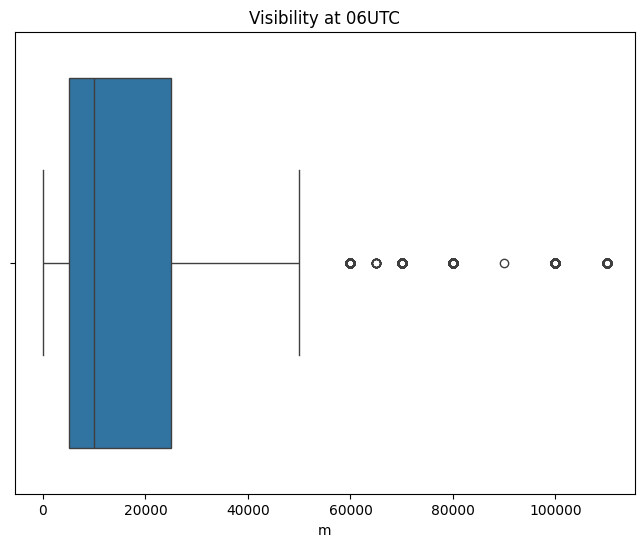

In [112]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='sicht_i', data=data_cleaned)
plt.title('Visibility at 06UTC')
plt.xlabel('m')
plt.show()

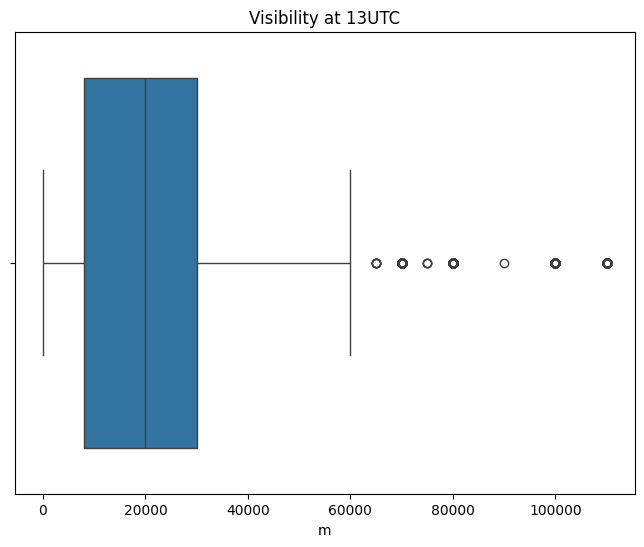

In [113]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='sicht_ii', data=data_cleaned)
plt.title('Visibility at 13UTC')
plt.xlabel('m')
plt.show()

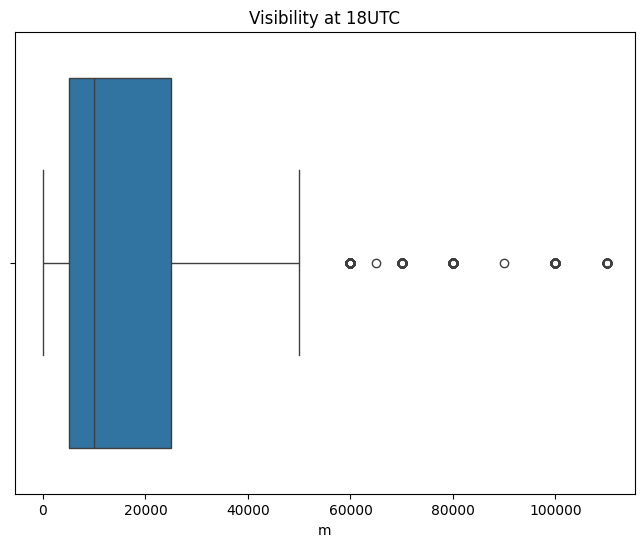

In [114]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='sicht_iii', data=data_cleaned)
plt.title('Visibility at 18UTC')
plt.xlabel('m')
plt.show()

The distribution is skewed, with outliers above 60,000 meters.

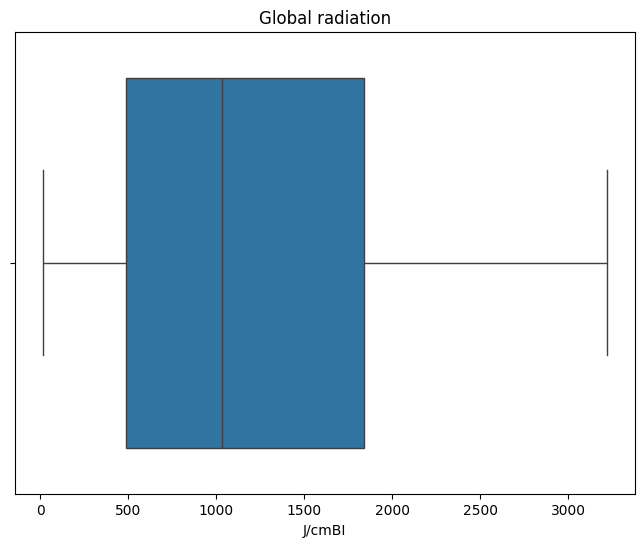

In [115]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='cglo_j', data=data_cleaned)
plt.title('Global radiation')
plt.xlabel('J/cmВІ')
plt.show()

The distribution appears symmetrical, with no extreme outliers. Values are concentrated between 500 and 2,500 J/cm².

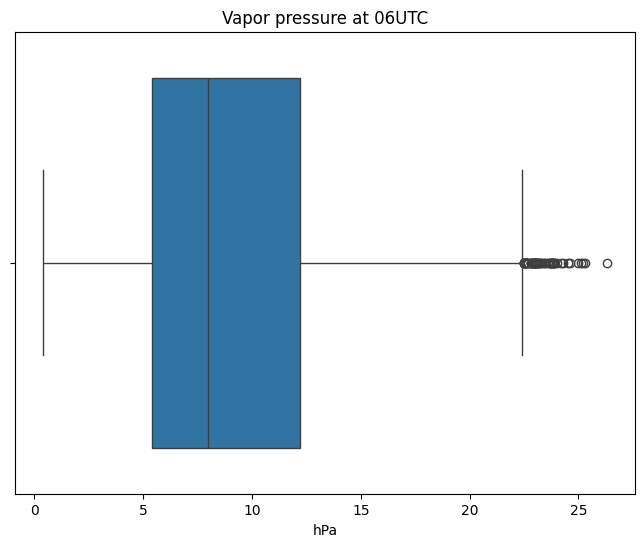

In [116]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='dampf_i', data=data_cleaned)
plt.title('Vapor pressure at 06UTC')
plt.xlabel('hPa')
plt.show()

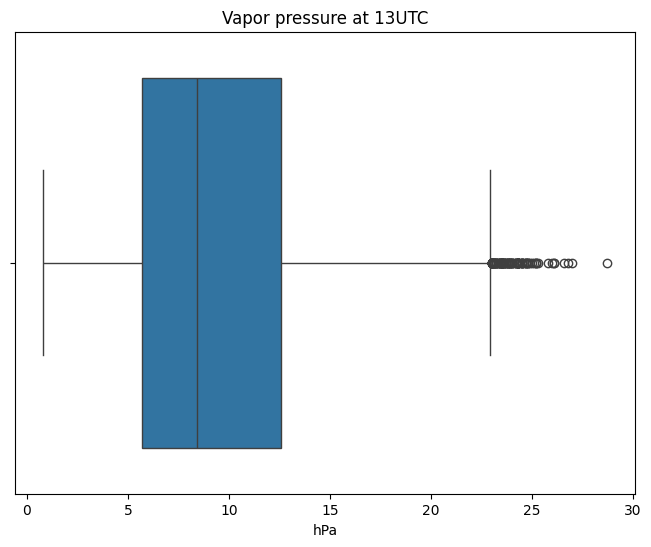

In [117]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='dampf_ii', data=data_cleaned)
plt.title('Vapor pressure at 13UTC')
plt.xlabel('hPa')
plt.show()

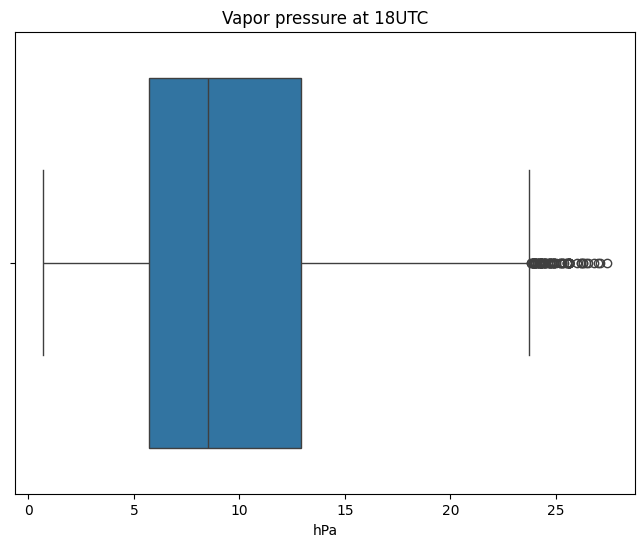

In [118]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='dampf_iii', data=data_cleaned)
plt.title('Vapor pressure at 18UTC')
plt.xlabel('hPa')
plt.show()

The distribution has several outliers, especially above 25 hPa.

# 4. Missing values

First let's drop the columns which we don't need anymore after feature engineering in the previous section:

In [119]:
data_cleaned = data_cleaned.drop(['rra_manu_i', 'rra_manu_iii', 'sha_manu'], axis=1)

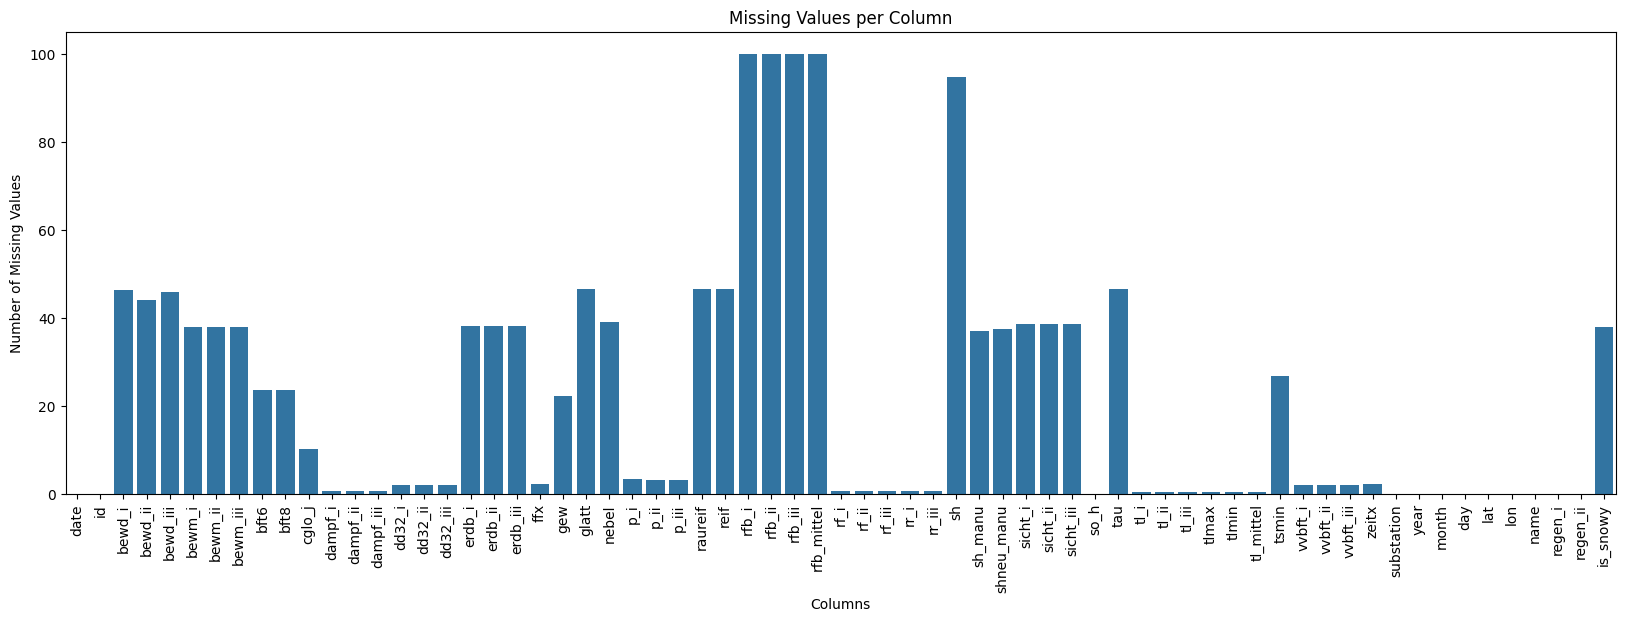

In [120]:
# Check missing values
missing_values = data_cleaned.isnull().sum()
missing_values_per = missing_values / len(data_cleaned) * 100

# Create a bar plot for missing values
plt.figure(figsize=(20, 6))
sns.barplot(x=missing_values.index, y=missing_values_per.values)
plt.xticks(rotation=90)
plt.title("Missing Values per Column")
plt.ylabel("Number of Missing Values")
plt.xlabel("Columns")
plt.show()

## 4.1 High missing values

In [121]:
# Identify columns with >50% missing values
columns_to_drop = missing_values_per[missing_values_per > 50].index
print("Dropped the columns: ", columns_to_drop.values)
missing_values_per = missing_values_per[missing_values_per <= 50]

# Drop the identified columns from the DataFrame
data_cleaned = data_cleaned.drop(columns=columns_to_drop)

# Now filtered_data contains the DataFrame with the columns dropped.
print("Dataset size after removing columns with 100% missing values:", data_cleaned.shape)

Dropped the columns:  ['rfb_i' 'rfb_ii' 'rfb_iii' 'rfb_mittel' 'sh']
Dataset size after removing columns with 100% missing values: (54810, 62)


## 4.2 Moderate missing values

In [122]:
columns_with_moderate_missing = missing_values_per[missing_values_per > 5]

In [123]:
# Filter `parameter_data` to include only parameters with missing values
# Extract the parameter names from `columns_with_moderate_missing`
columns_with_moderate_missing_names = columns_with_moderate_missing.index

# Filter `parameter_data` based on these parameter names
parameters_with_moderate_missing = parameters_data[parameters_data['Parameterkürzel'].isin(columns_with_moderate_missing_names)]

# Merge the missing percentages with the explanations
# Create a DataFrame for the missing percentages
missing_df = columns_with_moderate_missing.reset_index()
missing_df.columns = ['Parameterkürzel', 'Missing Percentage']

# Merge the two DataFrames on the `Parameterkürzel` column
merged_data = pd.merge(missing_df, parameters_with_moderate_missing, on='Parameterkürzel', how='inner')

print("Parameters with Missing Values > 5%:")
print(merged_data[['Parameterkürzel','Beschreibung', 'Missing Percentage']])


Parameters with Missing Values > 5%:
   Parameterkürzel                                       Beschreibung  \
0           bewd_i  Bewölkungsdichte zum Beobachtungstermin I (06 ...   
1          bewd_ii  Bewölkungsdichte zum Beobachtungstermin II (13...   
2         bewd_iii  Bewölkungsdichte zum Beobachtungstermin III (1...   
3           bewm_i  Bewölkungsmenge zum Beobachtungstermin I (06 U...   
4          bewm_ii  Bewölkungsmenge zum Beobachtungstermin II (13 ...   
5         bewm_iii  Bewölkungsmenge zum Beobachtungstermin III (18...   
6             bft6  Windstärke >= 6 Beaufort oder >= 60 km/h - Cod...   
7             bft8  Windstärke >= 8 Beaufort oder >= 80 km/h - Cod...   
8           cglo_j  Globalstrahlung, kalibrierte 24-Stundensumme a...   
9           erdb_i  Erdbodenzustand zum Beobachtungstermin I (06 U...   
10         erdb_ii  Erdbodenzustand zum Beobachtungstermin II (13 ...   
11        erdb_iii  Erdbodenzustand zum Beobachtungstermin III (18...   
12            

C:\Users\Мария\AppData\Local\Temp\ipykernel_15616\1962949356.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_station = relevant_parameters.groupby(stations_column).apply(lambda x: x.isnull().mean() * 100)


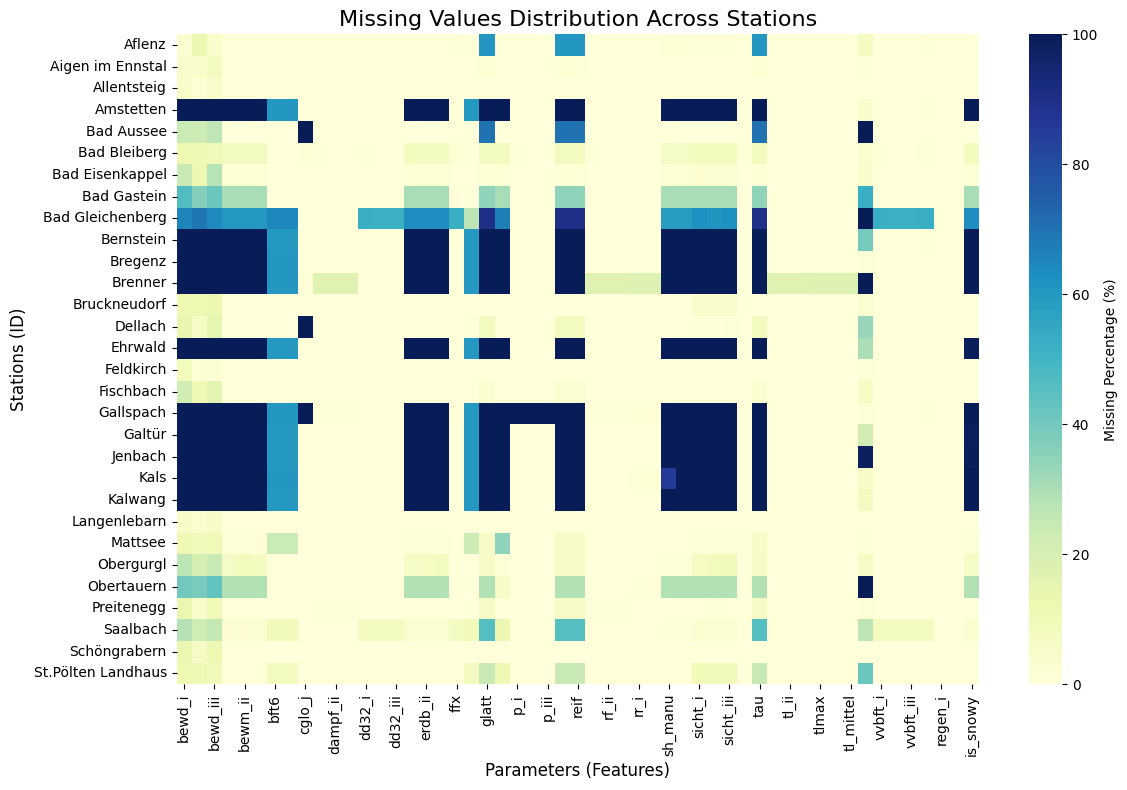

In [124]:
stations_column = 'name'

# Filter dataset to retain only relevant parameters, dropping unnecessary columns
relevant_parameters = data_cleaned.drop(columns=['date', 'year', 'month', 'day', 'lat', 'lon', 'id', 'substation'])

# Calculate the percentage of missing values for each station
missing_by_station = relevant_parameters.groupby(stations_column).apply(lambda x: x.isnull().mean() * 100)

# Prepare filtered dataset for plotting
# Drop the station column if it's included in the resulting DataFrame
if stations_column in missing_by_station.columns:
    filtered_missing_by_station = missing_by_station.drop(columns=[stations_column])
else:
    filtered_missing_by_station = missing_by_station

# Plot the heatmap of missing values distribution across stations
plt.figure(figsize=(12, 8))
sns.heatmap(
    filtered_missing_by_station,
    cmap="YlGnBu",
    annot=False,
    cbar_kws={'label': 'Missing Percentage (%)'}
)

plt.title("Missing Values Distribution Across Stations", fontsize=16)
plt.xlabel("Parameters (Features)", fontsize=12)
plt.ylabel("Stations (ID)", fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()


In [125]:
# Group by station name and calculate the missing percentage
missing_by_name = data_cleaned.groupby('name').apply(lambda x: x.isnull().mean() * 100)

# Sort the results by the overall missing percentage for better understanding
missing_by_name['Overall Missing Percentage'] = missing_by_name.mean(axis=1)
missing_by_name_sorted = missing_by_name.sort_values('Overall Missing Percentage', ascending=False)

print(missing_by_name_sorted['Overall Missing Percentage'])

name
Gallspach             41.812773
Brenner               40.771934
Jenbach               36.739234
Bernstein             35.828169
Ehrwald               35.632184
Galtür                35.497113
Kalwang               35.310839
Amstetten             35.270230
Bregenz               35.195190
Kals                  35.143104
Bad Gleichenberg      32.853082
Bad Gastein           11.437753
Obertauern            11.096103
Bad Aussee             8.943800
Saalbach               6.892138
Aflenz                 4.464396
St.Pölten Landhaus     3.860551
Dellach                3.406784
Bad Bleiberg           3.038650
Obergurgl              3.009517
Mattsee                2.907993
Bad Eisenkappel        1.753271
Fischbach              1.152074
Preitenegg             0.961386
Bruckneudorf           0.887229
Schöngrabern           0.526158
Aigen im Ennstal       0.435228
Feldkirch              0.258665
Langenlebarn           0.250719
Allentsteig            0.204813
Name: Overall Missing Percentage, d

C:\Users\Мария\AppData\Local\Temp\ipykernel_15616\3209074930.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_name = data_cleaned.groupby('name').apply(lambda x: x.isnull().mean() * 100)


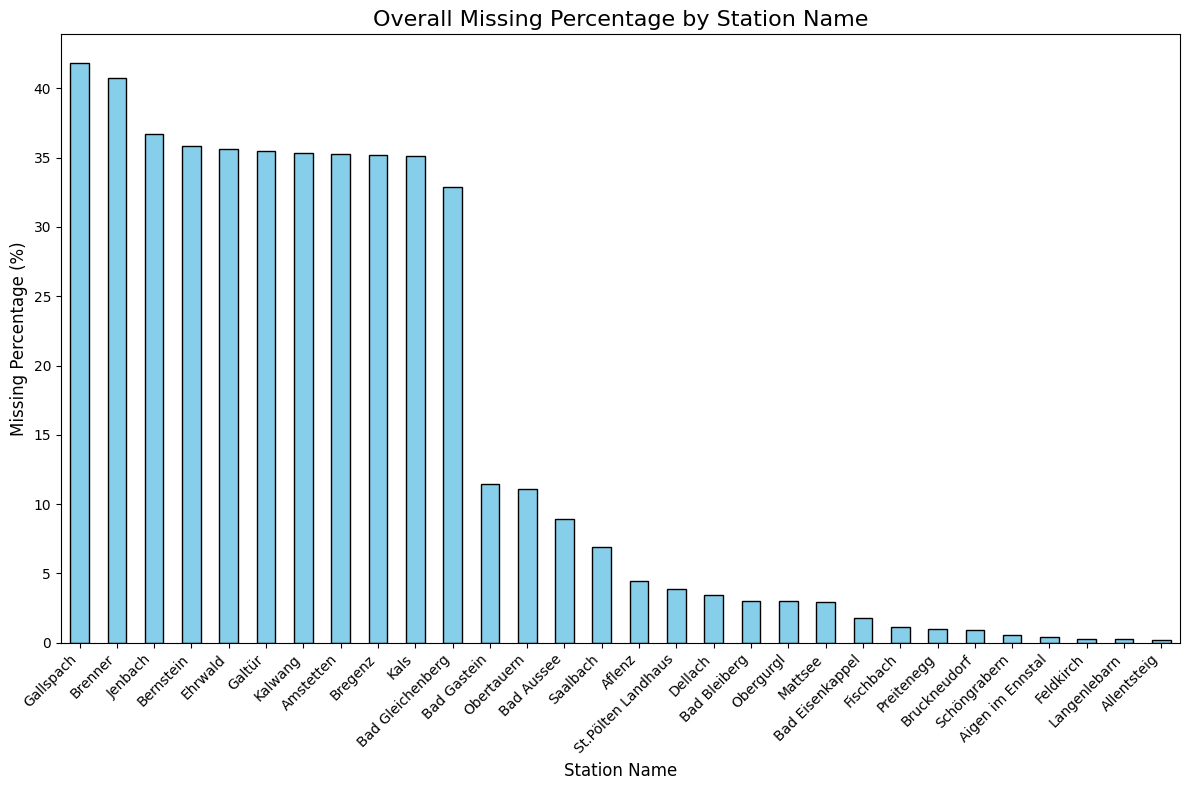

In [126]:
# Extract overall missing percentage
station_missing_summary = missing_by_name_sorted['Overall Missing Percentage']

plt.figure(figsize=(12, 8))
station_missing_summary.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title("Overall Missing Percentage by Station Name", fontsize=16)
plt.xlabel("Station Name", fontsize=12)
plt.ylabel("Missing Percentage (%)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 5. Preprocessing

## 5.1 Check if there are missing values in target columns

In [127]:
rows_with_nan_tlmax = data_cleaned[data_cleaned['tlmax'].isnull()]
print('Rows with missing maximum temperature:', rows_with_nan_tlmax.shape[0])
print(rows_with_nan_tlmax['name'].value_counts())

Rows with missing maximum temperature: 328
name
Brenner         322
Bad Bleiberg      4
Obertauern        1
Saalbach          1
Name: count, dtype: int64


In [128]:
rows_with_nan_tlmin = data_cleaned[data_cleaned['tlmin'].isnull()]
print('Rows with missing minimum temperature:', rows_with_nan_tlmin.shape[0])
print(rows_with_nan_tlmin['name'].value_counts())

Rows with missing minimum temperature: 327
name
Brenner         322
Bad Bleiberg      4
Obertauern        1
Name: count, dtype: int64


In [129]:
rows_with_nan_tl_mittel = data_cleaned[data_cleaned['tl_mittel'].isnull()]
print('Rows with missing mean temperature:', rows_with_nan_tl_mittel.shape[0])
print(rows_with_nan_tl_mittel['name'].value_counts())

Rows with missing mean temperature: 328
name
Brenner         322
Bad Bleiberg      4
Obertauern        1
Saalbach          1
Name: count, dtype: int64


## 5.2 Handling missing values

### 5.2.1 Simply delete columns with a high percentage of missing values

In [130]:
missing_percentage = data_cleaned.isnull().sum() / len(data_cleaned) * 100

# Identify columns with more than 10% missing values
columns_to_drop = missing_percentage[missing_percentage > 10].index
print('Columns to drop:', columns_to_drop)

Columns to drop: Index(['bewd_i', 'bewd_ii', 'bewd_iii', 'bewm_i', 'bewm_ii', 'bewm_iii',
       'bft6', 'bft8', 'cglo_j', 'erdb_i', 'erdb_ii', 'erdb_iii', 'gew',
       'glatt', 'nebel', 'raureif', 'reif', 'sh_manu', 'shneu_manu', 'sicht_i',
       'sicht_ii', 'sicht_iii', 'tau', 'tsmin', 'is_snowy'],
      dtype='object')


In [131]:
print("Current size of the dataset:", data_cleaned.shape)
data_cleaned = data_cleaned.drop(columns=columns_to_drop)
print("Size of dataset after removing columns with >10% of missing values:", data_cleaned.shape)

Current size of the dataset: (54810, 62)
Size of dataset after removing columns with >10% of missing values: (54810, 37)


### 5.2.2. Impute missing values for features with <10% missing values

For other columns use KNNImputer. To avoid data leakage, the imputation should be done separately for training and testing data after splitting the dataset by year.

In [134]:
data_cleaned = data_cleaned.drop(['date', 'zeitx', 'substation', 'name'], axis=1)

In [135]:
# Split the data into training (2016-2019) and testing (2020)
train_data = data_cleaned[data_cleaned['year'] < 2020]
test_data = data_cleaned[data_cleaned['year'] == 2020]

In [136]:
# Initialize the KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)

# Apply KNNImputer separately
train_data_imputed = knn_imputer.fit_transform(train_data)
test_data_imputed = knn_imputer.transform(test_data)

# Convert back to DataFrame
train_data_imputed_df = pd.DataFrame(train_data_imputed, columns=train_data.columns)
test_data_imputed_df = pd.DataFrame(test_data_imputed, columns=test_data.columns)

In [137]:
train_data_imputed_df

,id,dampf_i,dampf_ii,dampf_iii,dd32_i,dd32_ii,dd32_iii,ffx,p_i,p_ii,...,vvbft_i,vvbft_ii,vvbft_iii,year,month,day,lat,lon,regen_i,regen_ii
0,8.0,4.1,4.4,3.9,0.0,16.0,0.0,3.2,994.60,994.00,...,0.0,1.0,0.0,2016.0,1.0,1.0,46.872220,15.903610,0.0,0.0
1,66.0,4.4,3.8,2.5,16.0,20.0,20.0,4.3,808.90,807.60,...,1.0,1.0,1.0,2016.0,1.0,1.0,46.866940,11.024440,0.0,0.0
2,68.0,5.2,5.0,4.1,24.0,28.0,32.0,7.6,828.00,827.90,...,3.0,2.0,1.0,2016.0,1.0,1.0,47.248890,13.559720,0.0,0.0
3,93.0,4.4,5.7,5.8,20.0,20.0,20.0,9.5,995.40,994.00,...,1.0,3.0,2.0,2016.0,1.0,1.0,48.199720,15.631110,0.0,0.0
4,27.0,5.6,6.8,6.1,20.0,28.0,16.0,4.7,932.74,931.32,...,1.0,2.0,1.0,2016.0,1.0,1.0,48.204220,13.825000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43825,37.0,4.6,6.0,5.6,16.0,28.0,28.0,10.5,996.60,998.00,...,1.0,4.0,3.0,2019.0,12.0,31.0,48.603330,16.061670,0.0,0.0
43826,20.0,4.3,6.3,4.8,0.0,20.0,8.0,3.6,917.60,917.50,...,0.0,1.0,1.0,2019.0,12.0,31.0,47.404170,10.920000,0.0,0.0
43827,71.0,3.7,5.1,4.1,4.0,20.0,24.0,5.9,908.50,907.00,...,1.0,1.0,1.0,2019.0,12.0,31.0,46.938333,14.920278,0.0,0.0
43828,43.0,4.0,3.5,4.3,4.0,28.0,8.0,12.9,875.40,874.80,...,1.0,3.0,2.0,2019.0,12.0,31.0,47.004780,12.646500,0.0,0.0


In [139]:
train_data_imputed_df = train_data_imputed_df.drop(['tl_i', 'tl_ii', 'tl_iii'], axis=1)
test_data_imputed_df = test_data_imputed_df.drop(['tl_i', 'tl_ii', 'tl_iii'], axis=1)

## 5.3 Renaming the columns

For better understanding let's rename the feature names:

In [140]:
train_data_imputed_df.columns.values

array(['id', 'dampf_i', 'dampf_ii', 'dampf_iii', 'dd32_i', 'dd32_ii',
       'dd32_iii', 'ffx', 'p_i', 'p_ii', 'p_iii', 'rf_i', 'rf_ii',
       'rf_iii', 'rr_i', 'rr_iii', 'so_h', 'tlmax', 'tlmin', 'tl_mittel',
       'vvbft_i', 'vvbft_ii', 'vvbft_iii', 'year', 'month', 'day', 'lat',
       'lon', 'regen_i', 'regen_ii'], dtype=object)

In [142]:
# New column names
new_columns = [
    'id',
    'vapor_pressure_1', 'vapor_pressure_2', 'vapor_pressure_3', 
    'wind_direction_1', 'wind_direction_2', 'wind_direction_3', 
    'max_wind_speed', 
    'air_pressure_1', 'air_pressure_2', 'air_pressure_3', 
    'relative_humidity_1', 'relative_humidity_2', 'relative_humidity_3', 
    'precipitation_1', 'precipitation_2', 
    'sunshine_duration', 
    'temperature_max', 'temperature_min', 'temperature_mean',
    'wind_strength_1', 'wind_strength_2', 'wind_strength_3', 
    'year', 'month', 'day', 
    'lat', 'lon', 
    'rain_indicator_1', 'rain_indicator_2'
]

train_data_imputed_df.rename(columns=dict(zip(train_data_imputed_df.columns, new_columns)), inplace=True)
test_data_imputed_df.rename(columns=dict(zip(test_data_imputed_df.columns, new_columns)), inplace=True)

In [143]:
print("Cleaned dataset contains the following features:", train_data_imputed_df.columns.values)

Cleaned dataset contains the following features: ['id' 'vapor_pressure_1' 'vapor_pressure_2' 'vapor_pressure_3'
 'wind_direction_1' 'wind_direction_2' 'wind_direction_3' 'max_wind_speed'
 'air_pressure_1' 'air_pressure_2' 'air_pressure_3' 'relative_humidity_1'
 'relative_humidity_2' 'relative_humidity_3' 'precipitation_1'
 'precipitation_2' 'sunshine_duration' 'temperature_max' 'temperature_min'
 'temperature_mean' 'wind_strength_1' 'wind_strength_2' 'wind_strength_3'
 'year' 'month' 'day' 'lat' 'lon' 'rain_indicator_1' 'rain_indicator_2']


## 5.4 Lag features


Since a non-sequential model, RandomForest, will be used, we need to create lag features. We need to keep the dimensionality manageable, so we will not lag all the features,

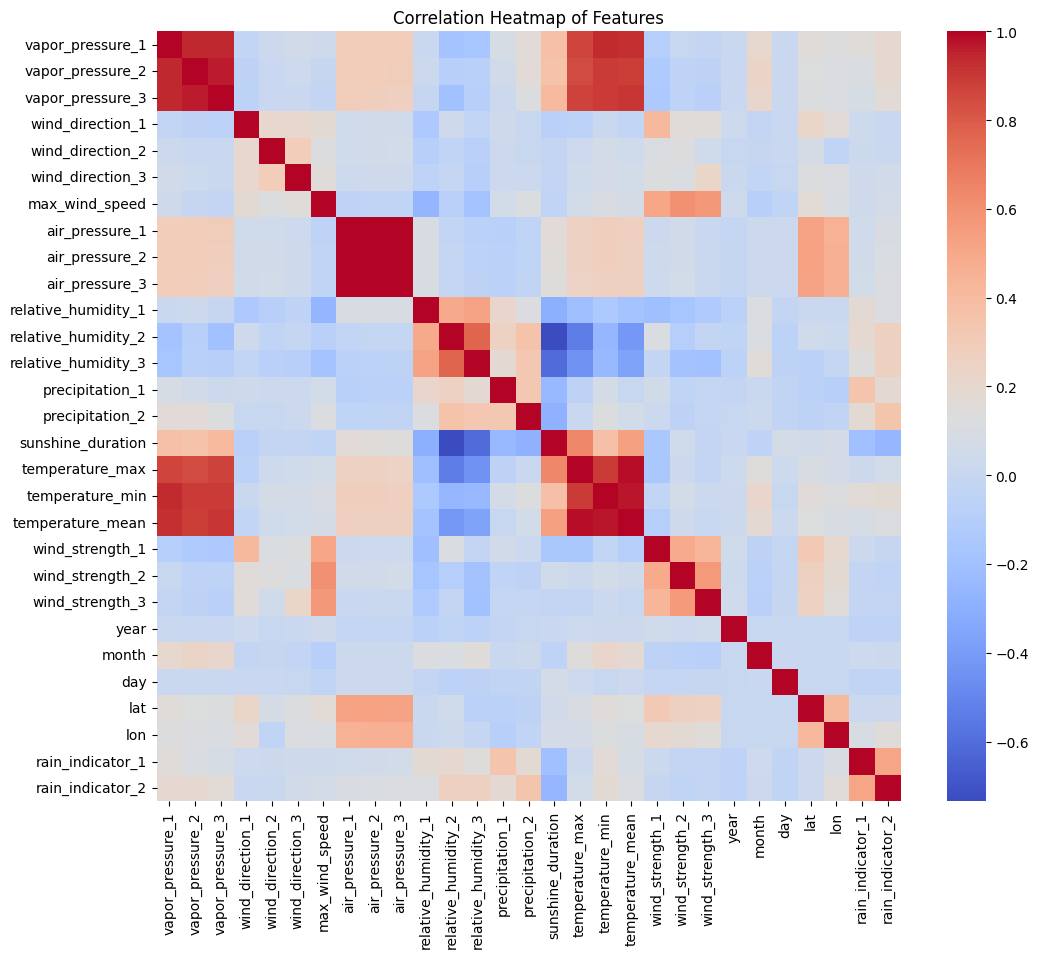

In [144]:
# Compute the correlation matrix
correlation_matrix = train_data_imputed_df.drop(['id'],axis=1).corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', cbar=True)

# Add title
plt.title("Correlation Heatmap of Features")

# Show the plot
plt.show()

In [145]:
# Define target columns
target_columns = ['temperature_max', 'temperature_min', 'temperature_mean']

# Correlation of all features with the targets
correlation_with_target = train_data_imputed_df.corr()[target_columns]

# Display features with strong correlations (above 0.5 or below -0.5)
strong_correlation = correlation_with_target[(correlation_with_target.abs() > 0.5).any(axis=1)]
print("Features with strong correlation to targets:")
print(strong_correlation)

# Display features with weak correlations (below 0.1)
weak_correlation = correlation_with_target[(correlation_with_target.abs() < 0.1).all(axis=1)]
print("\nFeatures with weak correlation to targets:")
print(weak_correlation)

Features with strong correlation to targets:
                     temperature_max  temperature_min  temperature_mean
vapor_pressure_1            0.866564         0.935756          0.920330
vapor_pressure_2            0.844272         0.891620          0.887633
vapor_pressure_3            0.874073         0.893382          0.905556
relative_humidity_2        -0.532482        -0.256628         -0.422099
sunshine_duration           0.635606         0.371630          0.533167
temperature_max             1.000000         0.897286          0.979979
temperature_min             0.897286         1.000000          0.967201
temperature_mean            0.979979         0.967201          1.000000

Features with weak correlation to targets:
                  temperature_max  temperature_min  temperature_mean
id                      -0.067341        -0.045376         -0.059227
wind_direction_1        -0.060361         0.013393         -0.028657
wind_direction_2         0.031758         0.070363      

We will drop some features with weak correlation to targets:

In [146]:
train_data_imputed_df = train_data_imputed_df.drop(['wind_direction_1', 'wind_direction_2', 'wind_direction_3', 'wind_strength_1', 'wind_strength_2', 'wind_strength_3', 'precipitation_1', 'precipitation_2'], axis=1)
test_data_imputed_df = test_data_imputed_df.drop(['wind_direction_1', 'wind_direction_2', 'wind_direction_3', 'wind_strength_1', 'wind_strength_2', 'wind_strength_3', 'precipitation_1', 'precipitation_2'], axis=1)

In [147]:
features_to_lag = [
    'vapor_pressure_1', 
    'vapor_pressure_2',
    'vapor_pressure_3', 
    'sunshine_duration', 
    'temperature_max',
    'temperature_mean',
    'temperature_min'
]

In [148]:
# Define lag periods
lags = [7, 14, 28]

# Create lagged features for grouped data
for lag in lags:
    for feature in features_to_lag:
        # Group by station and apply shift
        train_data_imputed_df[f'{feature}_lag_{lag}'] = train_data_imputed_df.groupby('id')[feature].shift(lag)
        test_data_imputed_df[f'{feature}_lag_{lag}'] = test_data_imputed_df.groupby('id')[feature].shift(lag)

In [149]:
# Drop rows with NaN values resulting from lagging
train_data_imputed_df = train_data_imputed_df.dropna().reset_index(drop=True)
test_data_imputed_df = test_data_imputed_df.dropna().reset_index(drop=True)

In [150]:
print(train_data_imputed_df[['id', 'year', 'month', 'day', 'temperature_mean', 'temperature_mean_lag_7']].head(20))

      id    year  month   day  temperature_mean  temperature_mean_lag_7
0    8.0  2016.0    1.0  29.0               6.4                    -2.5
1   66.0  2016.0    1.0  29.0               1.5                    -6.0
2   68.0  2016.0    1.0  29.0               1.8                    -9.1
3   93.0  2016.0    1.0  29.0               7.8                    -7.6
4   27.0  2016.0    1.0  29.0               6.4                    -8.8
5    7.0  2016.0    1.0  29.0               2.4                    -9.2
6   18.0  2016.0    1.0  29.0               7.0                    -5.4
7   24.0  2016.0    1.0  29.0               7.8                    -5.1
8   42.0  2016.0    1.0  29.0               5.1                    -5.8
9   44.0  2016.0    1.0  29.0               5.3                   -10.4
10   4.0  2016.0    1.0  29.0               6.2                    -9.5
11  13.0  2016.0    1.0  29.0               6.7                    -5.5
12  21.0  2016.0    1.0  29.0               4.2                 

In [151]:
# Check if everything's correct
filtered_row = train_data_imputed_df[
    (train_data_imputed_df['id'] == 8) & 
    (train_data_imputed_df['year'] == 2016) & 
    (train_data_imputed_df['month'] == 4) & 
    (train_data_imputed_df['day'] == 1)
]

print(filtered_row['temperature_mean_lag_7'], filtered_row['temperature_mean_lag_14'], filtered_row['temperature_mean_lag_28'])

check_row_7 = train_data_imputed_df[
    (train_data_imputed_df['id'] == 8) & 
    (train_data_imputed_df['year'] == 2016) & 
    (train_data_imputed_df['month'] == 3) & 
    (train_data_imputed_df['day'] == 25)
]

check_row_14 = train_data_imputed_df[
    (train_data_imputed_df['id'] == 8) & 
    (train_data_imputed_df['year'] == 2016) & 
    (train_data_imputed_df['month'] == 3) & 
    (train_data_imputed_df['day'] == 18)
]

check_row_28 = train_data_imputed_df[
    (train_data_imputed_df['id'] == 8) & 
    (train_data_imputed_df['year'] == 2016) & 
    (train_data_imputed_df['month'] == 3) & 
    (train_data_imputed_df['day'] == 4)
]

print(check_row_7['temperature_mean'], check_row_14['temperature_mean'], check_row_28['temperature_mean'])

1890    6.4
Name: temperature_mean_lag_7, dtype: float64 1890    6.3
Name: temperature_mean_lag_14, dtype: float64 1890    6.3
Name: temperature_mean_lag_28, dtype: float64
1680    6.4
Name: temperature_mean, dtype: float64 1470    6.3
Name: temperature_mean, dtype: float64 1050    6.3
Name: temperature_mean, dtype: float64


## 5.5 Defining the forecast horizon

In [152]:
# Define the forecast horizons in days
forecast_horizons = range(21, 36)  # Predict for 21 to 35 days ahead

# Create target columns
for horizon in forecast_horizons:
    for target in ['temperature_max', 'temperature_min', 'temperature_mean']:
        train_data_imputed_df[f'{target}_target_{horizon}'] = train_data_imputed_df.groupby('id')[target].shift(-horizon)
        test_data_imputed_df[f'{target}_target_{horizon}'] = test_data_imputed_df.groupby('id')[target].shift(-horizon)

After defining the forecast horizon, some rows at the end of each station's data will have NaN in the target columns due to shifting. Drop these rows:

In [153]:
# Drop rows with NaN values in the target columns
train_data_imputed_df = train_data_imputed_df.dropna().reset_index(drop=True)
test_data_imputed_df = test_data_imputed_df.dropna().reset_index(drop=True)

In [154]:
print(train_data_imputed_df[['id', 'year', 'month', 'day', 'temperature_mean_target_21']].head(20))

      id    year  month   day  temperature_mean_target_21
0    8.0  2016.0    1.0  29.0                         5.2
1   66.0  2016.0    1.0  29.0                        -6.4
2   68.0  2016.0    1.0  29.0                        -3.5
3   93.0  2016.0    1.0  29.0                         4.6
4   27.0  2016.0    1.0  29.0                         4.2
5    7.0  2016.0    1.0  29.0                         0.2
6   18.0  2016.0    1.0  29.0                         4.5
7   24.0  2016.0    1.0  29.0                         3.2
8   42.0  2016.0    1.0  29.0                         3.5
9   44.0  2016.0    1.0  29.0                         3.0
10   4.0  2016.0    1.0  29.0                         4.8
11  13.0  2016.0    1.0  29.0                         2.5
12  21.0  2016.0    1.0  29.0                         2.3
13  28.0  2016.0    1.0  29.0                        -4.4
14  16.0  2016.0    1.0  29.0                        -0.7
15  25.0  2016.0    1.0  29.0                         0.5
16  83.0  2016

## 5.6 Defining input and target features

In [155]:
input_features = [col for col in train_data_imputed_df.columns if 'target' not in col and 'id' not in col]
input_features

['vapor_pressure_1',
 'vapor_pressure_2',
 'vapor_pressure_3',
 'max_wind_speed',
 'air_pressure_1',
 'air_pressure_2',
 'air_pressure_3',
 'sunshine_duration',
 'temperature_max',
 'temperature_min',
 'temperature_mean',
 'year',
 'month',
 'day',
 'lat',
 'lon',
 'rain_indicator_1',
 'rain_indicator_2',
 'vapor_pressure_1_lag_7',
 'vapor_pressure_2_lag_7',
 'vapor_pressure_3_lag_7',
 'sunshine_duration_lag_7',
 'temperature_max_lag_7',
 'temperature_mean_lag_7',
 'temperature_min_lag_7',
 'vapor_pressure_1_lag_14',
 'vapor_pressure_2_lag_14',
 'vapor_pressure_3_lag_14',
 'sunshine_duration_lag_14',
 'temperature_max_lag_14',
 'temperature_mean_lag_14',
 'temperature_min_lag_14',
 'vapor_pressure_1_lag_28',
 'vapor_pressure_2_lag_28',
 'vapor_pressure_3_lag_28',
 'sunshine_duration_lag_28',
 'temperature_max_lag_28',
 'temperature_mean_lag_28',
 'temperature_min_lag_28']

In [156]:
# Define target columns for all forecast horizons
target_features = [f'temperature_max_target_{horizon}' for horizon in forecast_horizons] + \
                  [f'temperature_min_target_{horizon}' for horizon in forecast_horizons] + \
                  [f'temperature_mean_target_{horizon}' for horizon in forecast_horizons]

target_features

['temperature_max_target_21',
 'temperature_max_target_22',
 'temperature_max_target_23',
 'temperature_max_target_24',
 'temperature_max_target_25',
 'temperature_max_target_26',
 'temperature_max_target_27',
 'temperature_max_target_28',
 'temperature_max_target_29',
 'temperature_max_target_30',
 'temperature_max_target_31',
 'temperature_max_target_32',
 'temperature_max_target_33',
 'temperature_max_target_34',
 'temperature_max_target_35',
 'temperature_min_target_21',
 'temperature_min_target_22',
 'temperature_min_target_23',
 'temperature_min_target_24',
 'temperature_min_target_25',
 'temperature_min_target_26',
 'temperature_min_target_27',
 'temperature_min_target_28',
 'temperature_min_target_29',
 'temperature_min_target_30',
 'temperature_min_target_31',
 'temperature_min_target_32',
 'temperature_min_target_33',
 'temperature_min_target_34',
 'temperature_min_target_35',
 'temperature_mean_target_21',
 'temperature_mean_target_22',
 'temperature_mean_target_23',
 'tempe

Test the model on one step (21):

In [159]:
# Split the data into inputs (X) and targets (y)
X_train = train_data_imputed_df[input_features]
y_train = train_data_imputed_df['temperature_max_target_21']

X_test = test_data_imputed_df[input_features]
y_test = test_data_imputed_df['temperature_max_target_21']

In [160]:
y_train

0         6.2
1        -3.2
2        -1.1
3         7.4
4         6.0
         ... 
41935     5.3
41936    13.7
41937    10.6
41938     4.5
41939    18.5
Name: temperature_max_target_21, Length: 41940, dtype: float64

In [ ]:
# X_train = data_imputted_df[input_features]
# y_train = data_imputted_df[target_features]

## 5.7 Scaling

In [161]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler only on the training data
X_train_scaled = scaler.fit_transform(X_train)
# Transform the testing data using the same scaler
X_test_scaled = scaler.transform(X_test)

In [80]:
# # Initialize a separate scaler for the targets
# target_scaler = StandardScaler()

# # Fit the scaler on the training targets
# y_train_scaled = target_scaler.fit_transform(y_train)

# 6. Modeling


In [165]:
# Create LightGBM Dataset
lgb_train = lgb.Dataset(X_train_scaled, y_train)
lgb_test = lgb.Dataset(X_test_scaled, y_test, reference=lgb_train)

In [177]:
# Define LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Trees
    'num_leaves': 31,         # Maximum number of leaves in one tree
    'learning_rate': 0.05,    # Shrinkage rate
    'feature_fraction': 0.8,  # Proportion of features used per iteration
    'verbosity': 50           # Suppress logs
}

In [178]:
# Initialize the LightGBM regressor
model = LGBMRegressor(**params, n_estimators=500)

# Training with Progress Bar
print("[INFO] Training LightGBM model...")
start_time = time.time()

progress_bar = tqdm(total=500, desc="Training Progress", unit="iteration")

# Fit the model with progress bar
model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_test_scaled, y_test)],
    eval_metric='rmse',
)

progress_bar.close()
end_time = time.time()
print(f"[INFO] Training completed in {end_time - start_time:.2f} seconds.")

[INFO] Training LightGBM model...


Training Progress:   0%|                                                                | 0/500 [00:10<?, ?iteration/s]

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.806784
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.041374
[LightGBM] [Debug] init for col-wise cost 0.000803 seconds, init for row-wise cost 0.006787 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7894
[LightGBM] [Info] Number of data points in the train set: 41940, number of used features: 39
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Start training from score 14.300320
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Tra

Training Progress:   0%|                                                                | 0/500 [00:02<?, ?iteration/s]

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[INFO] Training completed in 2.93 seconds.


In [ ]:
# # Initialize the multi-output regressor
# model = MultiOutputRegressor(RandomForestRegressor(random_state=42, n_estimators=100))

# # Train the model
# model.fit(X_train, y_train)


### Evaluation

In [179]:
# Make predictions on the test set
print("[INFO] Making predictions...")
y_pred = model.predict(X_test_scaled)

# Evaluate the model
print("[INFO] Evaluating the model...")
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

[INFO] Making predictions...
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[INFO] Evaluating the model...
RMSE: 4.97
MAE: 4.00


C:\Users\Мария\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'num_leaves': [31, 64],
    'learning_rate': [0.01, 0.05],
    'min_data_in_leaf': [10, 20],
    'max_depth': [-1, 5, 10]
}

lgb_model = LGBMRegressor(n_estimators=500, **params)
grid_search = GridSearchCV(lgb_model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=3)
grid_search.fit(X_train_scaled, y_train)

print(f"Best Parameters: {grid_search.best_params_}")

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.812178
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.041650
[LightGBM] [Debug] init for col-wise cost 0.000492 seconds, init for row-wise cost 0.004562 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins

# 7. Evaluation

Evaluation metrics:
* **Root Mean Squared Error (RMSE)** measures the square root of the average squared difference between predicted and observed values.
* **Mean Absolute Error (MAE)** measures the average of the absolute differences between predicted and observed values.
* **Bias** measures the average difference between predicted and observed values, indicating if predictions are systematically over- or under-estimated.

| Metric      | RandomForest | RandomForest (with Hyperparameter Optimization) |
|-------------|------------------------|-------------------|
| **RMSE**    | 2.35                  | 2.15              |
| **MAE**     | 1.80                  | 1.65              |
| **Bias**    | 0.25                  | 0.10              |
